# crypto_ml scratch note
Cryptocurrency machine learning project 
## Project assumptions:
### Must have:
- Connect to cryptocurrency exchange API (Binance API) and download data
- Save data to database 
- Periodic data update
- Data analysis and prepering.
- Create a machine learning model 
- Result presentation and adapting the application to the user 

### Nice have:
- Copmarsion of different ML models
- Adding new options for user

### Vision:
- Creating a trading bot
- Creating a model based on reinforcement learning


In [ ]:
# pip install requests
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install sklearn

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [302]:
api_base_endpoint = "https://api.binance.com"
api_current_price = api_base_endpoint + "/api/v3/ticker/price"
api_historical_price = api_base_endpoint + "/api/v3/klines?limit=1000&symbol=BTCUSDT&interval=1d"

In [303]:
r_current_price = requests.get(api_current_price)
r_historical_price = requests.get(api_historical_price)

In [314]:
current_price = pd.read_json(r_current_price.text)


In [315]:
current_price

,symbol,price
0,ETHBTC,0.051582
1,LTCBTC,0.004771
2,BNBBTC,0.010985
3,NEOBTC,0.001668
4,QTUMETH,0.005088
...,...,...
1413,FORTHUSDT,34.998000
1414,CAKEGBP,29.196000
1415,DOGERUB,22.919000
1416,HOTBRL,0.082800


In [316]:
historical_price

,0,1,2,3,4,5,6,7,8,9,10,11
0,1533340800000,7412.27,7494.81,6926.00,7009.84,36288.426010,1533427199999,2.622830e+08,199335,17770.555156,1.286019e+08,0
1,1533427200000,7009.84,7089.87,6882.29,7024.19,32894.849782,1533513599999,2.299926e+08,148658,18335.956341,1.282162e+08,0
2,1533513600000,7024.19,7160.00,6821.00,6934.82,32760.191643,1533599999999,2.290718e+08,177378,17486.151576,1.223043e+08,0
3,1533600000000,6935.00,7150.46,6670.00,6720.06,45438.473501,1533686399999,3.163659e+08,247202,24012.696862,1.673436e+08,0
4,1533686400000,6720.63,6721.54,6123.00,6285.00,59550.536319,1533772799999,3.824608e+08,305603,30204.484969,1.940917e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1619308800000,50047.84,50567.91,46930.00,49066.77,58255.645004,1619395199999,2.867858e+09,1475479,27767.331394,1.367921e+09,0
996,1619395200000,49066.76,54356.62,48753.44,54001.39,86310.802124,1619481599999,4.555689e+09,2174544,43183.936749,2.277376e+09,0
997,1619481600000,54001.38,55460.00,53222.00,55011.97,54064.034675,1619567999999,2.949719e+09,1568666,25631.074629,1.398732e+09,0
998,1619568000000,55011.97,56428.00,53813.16,54846.22,55130.459015,1619654399999,3.020243e+09,1830042,26762.033422,1.466279e+09,0


,Open,High,Low,Close,Volume
Open time,,,,,
2018-08-04,7412.27,7494.81,6926.00,7009.84,36288.426010
2018-08-05,7009.84,7089.87,6882.29,7024.19,32894.849782
2018-08-06,7024.19,7160.00,6821.00,6934.82,32760.191643
2018-08-07,6935.00,7150.46,6670.00,6720.06,45438.473501
2018-08-08,6720.63,6721.54,6123.00,6285.00,59550.536319
...,...,...,...,...,...
2021-04-25,50047.84,50567.91,46930.00,49066.77,58255.645004
2021-04-26,49066.76,54356.62,48753.44,54001.39,86310.802124
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675


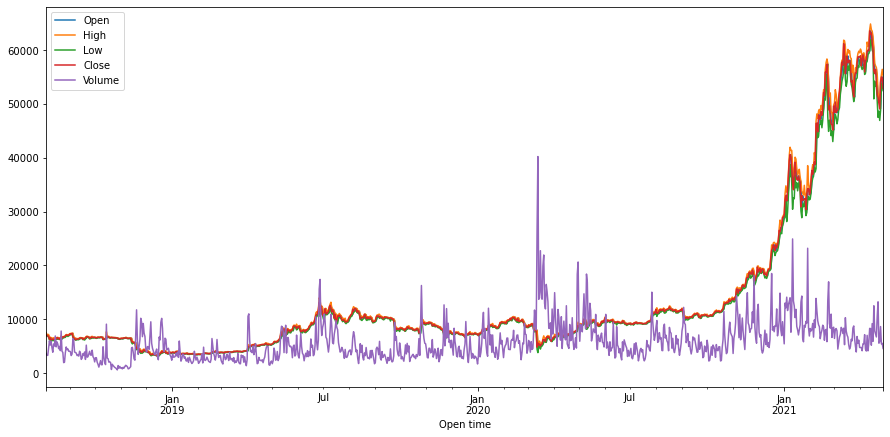

In [329]:
historical_price = pd.read_json(r_historical_price.text)

del_columns = historical_price.iloc[:,6:]
historical_price = historical_price.drop(del_columns, axis=1)
historical_price = historical_price.rename(columns={0:'Open time', 1:'Open', 2:'High', 3:'Low', 4:'Close', 5:'Volume'})
historical_price['Open time'] = pd.to_datetime(historical_price['Open time'], unit="ms")
historical_price = historical_price.set_index('Open time')

plot_price = historical_price.copy()
plot_price['Volume'] = plot_price['Volume']/10
plot_price.plot(figsize=(15,7))

historical_price

In [354]:
close_predict = historical_price.copy()

close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()
close_predict['next_day_close_price'] = close_predict['Close'].shift(-1)
close_predict = close_predict.dropna()

close_predict

,Open,High,Low,Close,Volume,close_3,close_9,next_day_close_price
Open time,,,,,,,,
2018-08-12,6222.55,6472.30,6130.00,6308.33,38567.770712,6228.230000,6576.487778,6246.35
2018-08-13,6308.56,6545.00,6145.04,6246.35,53895.828783,6262.343333,6491.655556,6188.08
2018-08-14,6248.25,6250.33,5880.00,6188.08,50186.745091,6247.586667,6398.754444,6267.16
2018-08-15,6188.08,6609.00,6172.11,6267.16,68806.687026,6233.863333,6324.570000,6311.75
2018-08-16,6265.27,6480.00,6205.60,6311.75,48515.254618,6255.663333,6279.202222,6584.49
...,...,...,...,...,...,...,...,...
2021-04-24,51110.56,51166.22,48657.14,50047.84,55361.512573,50954.646667,55133.464444,49066.77
2021-04-25,50047.84,50567.91,46930.00,49066.77,58255.645004,50079.916667,53770.350000,54001.39
2021-04-26,49066.76,54356.62,48753.44,54001.39,86310.802124,51038.666667,53103.097778,55011.97


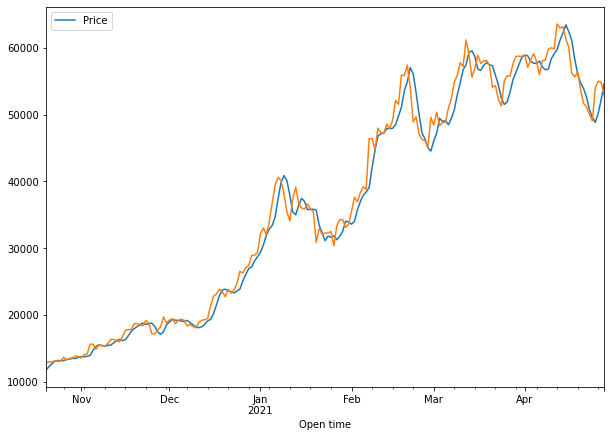

Predict score:  98.44
Crypto Price (y) = 1.22 * 3 Days Moving Average (x1) + -0.23 * 9 Days Moving Average (x2) + 80.68 (constant)


In [357]:
X = close_predict[['close_3', 'close_9']]

# Define dependent variable
y = close_predict['next_day_close_price']

t = 0.8
t = int(t*len(historical_price))
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

r2_score = model.score(X[t:], y[t:])*100
print("Predict score: ", float("{0:.2f}".format(r2_score)))

print("Crypto Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (model.coef_[0], model.coef_[1], model.intercept_))

In [336]:
close_predict = historical_price.copy()

close_predict['close_3'] = close_predict['Close'].rolling(window=3).mean()
close_predict['close_9'] = close_predict['Close'].rolling(window=9).mean()
close_predict = close_predict.dropna()

close_predict['predicted_crypto_price'] = model.predict(close_predict[['close_3', 'close_9']])

close_predict.tail()

,Open,High,Low,Close,Volume,close_3,close_9,predicted_crypto_price
Open time,,,,,,,,
2021-04-25,50047.84,50567.91,46930.00,49066.77,58255.645004,50079.916667,53770.350000,48841.767234
2021-04-26,49066.76,54356.62,48753.44,54001.39,86310.802124,51038.666667,53103.097778,50170.929145
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,52225.865747
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,54604.368722
2021-04-29,54846.23,55195.84,52476.69,52879.22,45648.069555,54245.803333,52495.237778,54238.379692


In [345]:
mean_predict = historical_price.copy()

mean_predict = mean_predict.iloc[:,0:4]
mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict['next_day_price'] = mean_predict['mean'].shift(-1)
mean_predict = mean_predict.dropna()

mean_predict

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,next_day_price
Open time,,,,,,
2018-08-04,7412.27,7494.81,6926.00,7009.84,7210.7300,7001.5475
2018-08-05,7009.84,7089.87,6882.29,7024.19,7001.5475,6985.0025
2018-08-06,7024.19,7160.00,6821.00,6934.82,6985.0025,6868.8800
2018-08-07,6935.00,7150.46,6670.00,6720.06,6868.8800,6462.5425
2018-08-08,6720.63,6721.54,6123.00,6285.00,6462.5425,6403.6175
...,...,...,...,...,...,...
2021-04-24,51110.56,51166.22,48657.14,50047.84,50245.4400,49153.1300
2021-04-25,50047.84,50567.91,46930.00,49066.77,49153.1300,51544.5525
2021-04-26,49066.76,54356.62,48753.44,54001.39,51544.5525,54423.8375


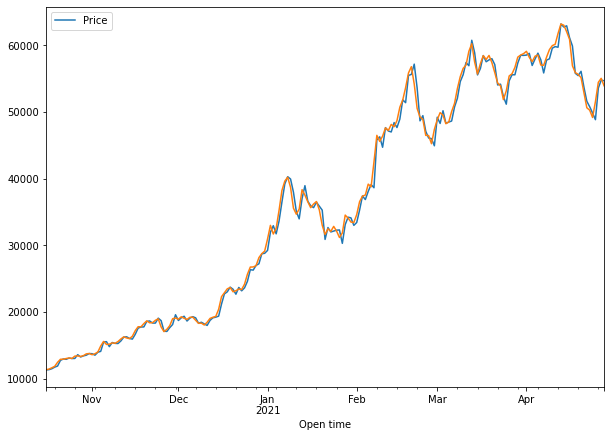

99.69

In [346]:
X = df[['Open', 'High', 'Low', 'Close']]
y = df['next_day_price']

t = 0.8
t = int(t*len(df))

X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

model = LinearRegression()
model.fit(X_train, y_train)

predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['Price'])

predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.show()

r2_score = model.score(X[t:], y[t:])*100
print("Predict score: ", float("{0:.2f}".format(r2_score)))

In [351]:
mean_predict = historical_price.copy()

mean_predict = mean_predict.iloc[:,0:4]
mean_predict['mean'] = 0

for i in range(len(mean_predict)):
    mean_predict['mean'].iloc[i] = mean_predict.iloc[i,:4].mean()
    
mean_predict = mean_predict.dropna()
mean_predict['predicted_crypto_price'] = model.predict(mean_predict[['Open', 'High', 'Low', 'Close']])
mean_predict.tail()

C:\Users\Windows 10\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,mean,predicted_crypto_price
Open time,,,,,,
2021-04-25,50047.84,50567.91,46930.00,49066.77,49153.1300,48823.988675
2021-04-26,49066.76,54356.62,48753.44,54001.39,51544.5525,53561.854129
2021-04-27,54001.38,55460.00,53222.00,55011.97,54423.8375,54744.389935
2021-04-28,55011.97,56428.00,53813.16,54846.22,55024.8375,54664.496544
2021-04-29,54846.23,55195.84,52476.69,52879.22,53849.4950,52756.609655


In [349]:

close_predict.tail()

,Open,High,Low,Close,Volume,close_3,close_9,predicted_crypto_price
Open time,,,,,,,,
2021-04-25,50047.84,50567.91,46930.00,49066.77,58255.645004,50079.916667,53770.350000,48841.767234
2021-04-26,49066.76,54356.62,48753.44,54001.39,86310.802124,51038.666667,53103.097778,50170.929145
2021-04-27,54001.38,55460.00,53222.00,55011.97,54064.034675,52693.376667,52976.648889,52225.865747
2021-04-28,55011.97,56428.00,53813.16,54846.22,55130.459015,54619.860000,52889.213333,54604.368722
2021-04-29,54846.23,55195.84,52476.69,52879.22,45648.069555,54245.803333,52495.237778,54238.379692
